***
# HCI - Spectral Deconvolution
*Matthew Kenworthy // Leiden Observatory*
***

This week you will look at a data cube taken with the Gemini Planet Imager (GPI) and find a companion in the multiple star system HD 1160.

## Spectral Deconvolution

The radial locations of speckles from the centre of the PSF are proportional to the observing wavelength. In contradiction to this difference, the location of the companion(s) of a star are fixes. Spectral deconvolution makes use of these two effects. We want to fit the speckle's spectrum by a model that is almost insensitive to the
signal produced by the companion. It requires that a certain speckle moves by at least one resolution element
between the shortest and the longest observing wavelength. 

In [1]:
%config InlineBackend.figure_format = 'retina' 

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)
    
    
def cen_scale (im, sca, dim_out, offset_in=(0,0), offset_out=(0,0), order=2):
    """cen_scale - scales image im at the coordinates of offset_in by factor sca
                   to output image with size dim_out, and puts the point at offset_in 
                   in the centre of the output image, with an optional delta offset 
                   of offset_out.
                   The parameter order is the order of the spline interpolation, 
                   where the default is 2. The order has to be in the range 0-5."""
    from scipy.ndimage import affine_transform
    # make a scaling matrix
    scale=np.array([[1./sca,0],[0,1./sca]])
    
    # -0.5 is there for fencepost counting error
    c_in = np.array(offset_in) - 0.5

    # c_out already starts at the centre of the output image
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-scaled to make offset correct
    offset_combined = c_in - c_out.dot(scale) - np.array(offset_out).dot(scale)
    
    # perform the transformation
    dst=affine_transform( \
        im,scale.T, order=order, offset=offset_combined, \
        output_shape=dim_out, cval=0.0)
    return(dst)

## Scaling an image

Let us look at a way to scale an image on the sky. We will only use the functions as provided in this notebook. You do not have to import other Python libraries to perform the scaling.

<div class="alert alert-block alert-success">
<b>Example 8.1:</b> Make a small image of shape <code>(11,17)</code>. We will be using <code>np.arange</code> to create an array ranging from 0 to 10 and thereafter reshape it in the desired shape.
</div>


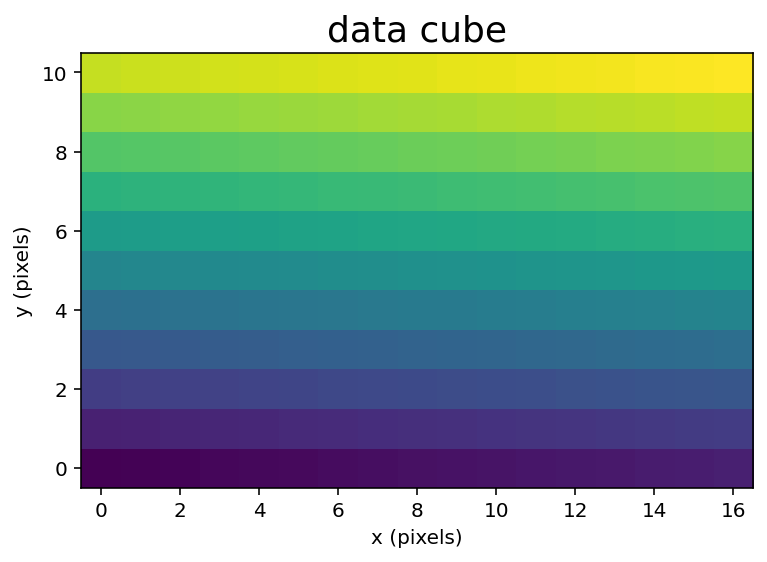

In [2]:
fig, ax = plt.subplots(1,1, figsize=(18,4))   

t1 = np.arange(11*17).reshape((11,17))

ax.imshow(t1)
ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
ax.set_title('data cube', fontsize=18) 

ax.imshow(t1)
plt.show()

<div class="alert alert-block alert-success">
<b>Example 8.1 (continued):</b> Then put this image into a larger image of shape <code>(22,34)</code> while using <code>cen_rot2()</code>. Convince yourself that you understand how scaling works in <code>cen_sca()</code> by trying just moving the image to a new place.
</div>

In [3]:
%run ../week_1/interactive

In [4]:
def interactive_scale_cube(sca,offx,offy):  
    fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize=(18,4))   
    fig.suptitle("Rotating an image using cen_rot2()",fontsize = 20, y=1.01)
    nx, ny = t1.shape
    
    ax.imshow(t1)
    ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
    ax.set_title('data cube', fontsize=16) 
    
    t_fixed = cen_scale(t1,0.75,(22,34), offset_out=(offx*nx, offy*ny))
    ax1.imshow(t_fixed)
    ax1.set_xlabel('x (pixels)');  ax1.set_ylabel('y (pixels)')  
    ax1.set_title("let's scale it a bit down.. shall we..", fontsize=16)  
    
    global t2
    t2 = cen_scale(t1,sca,(22,34), offset_out=(offx*nx, offy*ny))
    ax2.imshow(t2)
    ax2.set_xlabel('x (pixels)');  ax2.set_ylabel('y (pixels)')  
    ax2.set_title('scaled data cube offset ({0:.2f},{1:.2f})'.format(offx*nx, offy*ny), fontsize=16)  
    
    plt.show()
    return None

interactive_plot = interactive(interactive_scale_cube, 
                               sca=widgets.FloatSlider(value=0.75, min=0.05, max=1, step=0.05, readout_format='.2f', description="Scaling: "),
                               offx=widgets.FloatSlider(value=0, min=-1.0, max=1.0, step=0.10, readout_format='.2f', description="offset x"), 
                               offy=widgets.FloatSlider(value=0, min=-1.0, max=1.0, step=0.10, readout_format='.2f', description="offset y") )
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot



interactive(children=(FloatSlider(value=0.75, description='Scaling: ', max=1.0, min=0.05, step=0.05), FloatSli…

## Descaling an image

Let us look at a way to descale an image on the sky. We will only use the functions as provided in this notebook. You do not have to import other Python libraries to perform the scaling.

<div class="alert alert-block alert-success">
<b>Example 8.2:</b> In this example we will descale the image we obtained from the previous example, <code>t2</code>, to a size of <code>(11,17)</code>. We will be using the <code>descale()</code> function, given below, to do this. </div>


In [5]:
def descale(imin, scalefac, out_dims, star_cen):
    """descale - takes an image imin and a list of magnifications scalefac, and generate an output
       image of size outdims (where outdims is a tuple) and the scaling is done around the point 
       star_cen. star_cen is a tuple of (xstar, ystar) positions and xstar/ystar should be a numpy 
       array or a numpy single value"""
    # get shape of input image
    nim, nx, ny = imin.shape

    # sx and sy should be a single pair or contain scalefac.size number of elements
    sx, sy = star_cen
    if (sx.size == 1):
        sx = np.ones_like(scalefac) * sx
    if (sy.size == 1):
        sy = np.ones_like(scalefac) * sy
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_scale(frame_sq, scalefac[j], out_dims, offset_in=(sx[j], sy[j]))
        im_out[j,:,:] = frame_rot
                
    return(im_out)  

In [6]:
def interactive_descale_cube(sca,cenx,ceny):  
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(18,4))   
    fig.suptitle("Rotating an image using cen_rot2()",fontsize = 20, y=1.01)
    nx, ny = t2.shape
    
    ax.imshow(t2)
    ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
    ax.set_title('data cube', fontsize=16) 
    
    t2_arr = np.array([t2])
    t3 = descale(imin=t2_arr, scalefac=[sca], out_dims=(18,28), star_cen=(np.array(cenx),np.array(ceny)))
    plt.imshow(t3[0])
    ax1.imshow(t3[0])
    ax1.set_xlabel('x (pixels)');  ax1.set_ylabel('y (pixels)')  
    ax1.set_title("let's scale it a bit down.. shall we..", fontsize=16)  
        
    plt.show()
    return None

interactive_plot = interactive(interactive_descale_cube, 
                               sca=widgets.FloatSlider(value=0.75, min=0.05, max=1, step=0.05, readout_format='.2f', description="Scaling: "),
                               cenx=widgets.FloatSlider(value=7.0, min=0.0, max=30.0, step=1.0, readout_format='.2f', description="Centre Star x"), 
                               ceny=widgets.FloatSlider(value=7.0, min=0.0, max=40.0, step=1.0, readout_format='.2f', description="Centre Star y") )
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot



interactive(children=(FloatSlider(value=0.75, description='Scaling: ', max=1.0, min=0.05, step=0.05), FloatSli…

## Understanding the data cube containing our wavelength slices

We read in the data cube consisting of 37 image slices at different wavelengths across the J band.


In [7]:
im = fits.getdata('./HD1160_cube.fits', header=False) # HD1160 astrometric

print("Number of image slices in the data cube   ::    {}".format(im.shape[0]))
print("Pixel size of the images                  ::    {} x {}".format(im.shape[1],im.shape[2]))

Number of image slices in the data cube   ::    37
Pixel size of the images                  ::    281 x 281


With FITS files you also have the header information. We will store this information within the variable `he`.



In [8]:
im, he = fits.getdata('./HD1160_cube.fits', header=True) 

There are keywords and values associated with that keyword, which can be accessed by:

    value = he['keyword']
    
You can print out all the possible keywords with `print(he)` or examine the FITS file using `ds9`.



In [9]:
print("Location of sat. spot 3 of slice 36      ::    ({})".format(he['SATS36_3']))


Location of sat. spot 3 of slice 36      ::    (179.110 122.565)


We want to make sure that all the values in the image are non-NaN and non-Inf, as these will be a problem later on. Using `np.nan_to_num()` we are able to replace all `NaN` elements with zero and all `inf` (infinity) with large finite numbers.

In [10]:
im = np.nan_to_num(im)

## Identifying the main features in the image cube 

There are four 'satellite spots' that are generated by the coronagraph. These spots act as both astrometric and photometric references for each wavelength slice.

The four spot locations are stored in FITS header with keywords of the form `SATSn_m` where `n` is the image slice from 0 to 36 and `m` is the satellite spot number from 0 to 3.

---
<span style="  font-size:2em; color: SteelBlue;">Question 8.1</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Display the image at slice index 12 using `ax.imshow()` and a value range from 0 to 300.**
**On the same image as you just plotted, plot out four `Circles` to mark the four satellite spots.**

1. **Use a `for` loop to make the keyword as a formatted string for each spot, then use `np.fromstring()` to split the string into two `numpy` floats for the `x` and `y` coordinates.**
*  **Plot red circles of radius 10 pixels centred at the satellite spots.**
*  **Use `plt.Circle()` to generate a `Circle` object (make sure the Circle is not filled so that you can see the satellite spot).**
*  **Use `ax=plt.gca()` and `ax.add_artist()` to add the circle to the current plot.**
*  **The estimated position of the central star is stored in `PSFCENTX` and `PSFCENTY`. Plot this as a blue circle with a radius of 10 pixels.**

---
<span style="  font-size:2em; color: SteelBlue;">Question 8.2</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Write the number of the satellite spot in yellow onto the image using `ax.text()` so that you know which spot is which. Move the text so that it doesn't block out the satellite spot itself.**

***


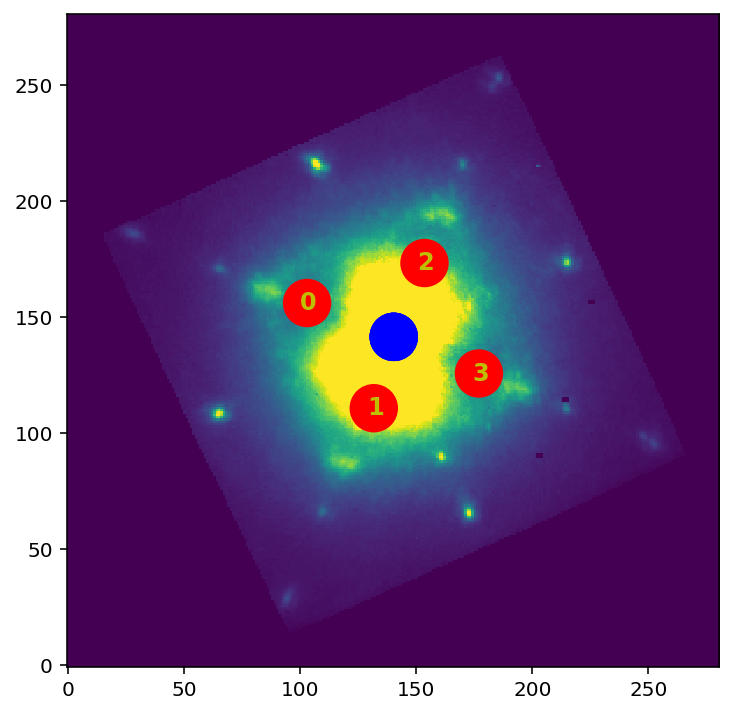

In [11]:
# Q1&Q2 answer here
# display the image at slice 12


fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(im[12],vmin=0,vmax=300,zorder=1)
offset=-3
for i in range(4):
    x,y = np.fromstring(he['SATS12_'+str(i)],sep=' ')
    centx = he['PSFCENTX']
    centy = he['PSFCENTY']
    circ = plt.Circle((x,y),10,color='r',label='satellites',zorder=2)
    circ_cent = plt.Circle((centx,centy),10,color='b',label='central star',zorder=2)
    ax.text(x+offset,y+offset,str(i),color='y',fontsize=12,fontweight='bold')
    ax.add_patch(circ)
    ax.add_patch(circ_cent)
    #ax.legend()
plt.show()
# Q1&Q2 end answer 

---
<span style="  font-size:2em; color: SteelBlue;">Question 8.3</span> <span style="  font-size:1em; color: SteelBlue;"> (1 point): </span>

**The satellite spot finding algorithm is not perfect, and one of the spots has been misidentified. Answer the question: Which one?**

***

In [28]:
# Q3 answer here

print("Spot 1 has been misidentified.")

# Q3 end answer 

Spot 1 has been misidentified.


## Determining the wavelength for each slice
The wavelength for each slice is stored in two FITS keywords:

* `CRVAL3` is the wavelength of slice 0 ( call this `wlen0` )

* `CD3_3` is wavelength change between each slice ( call this `dwlen` ).



---
<span style="  font-size:2em; color: SteelBlue;">Question 8.4</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Make a plot of slice number versus wavelength. Label the axes as 'Slice number' and 'Wavelength [$\mu$m]'.**

***


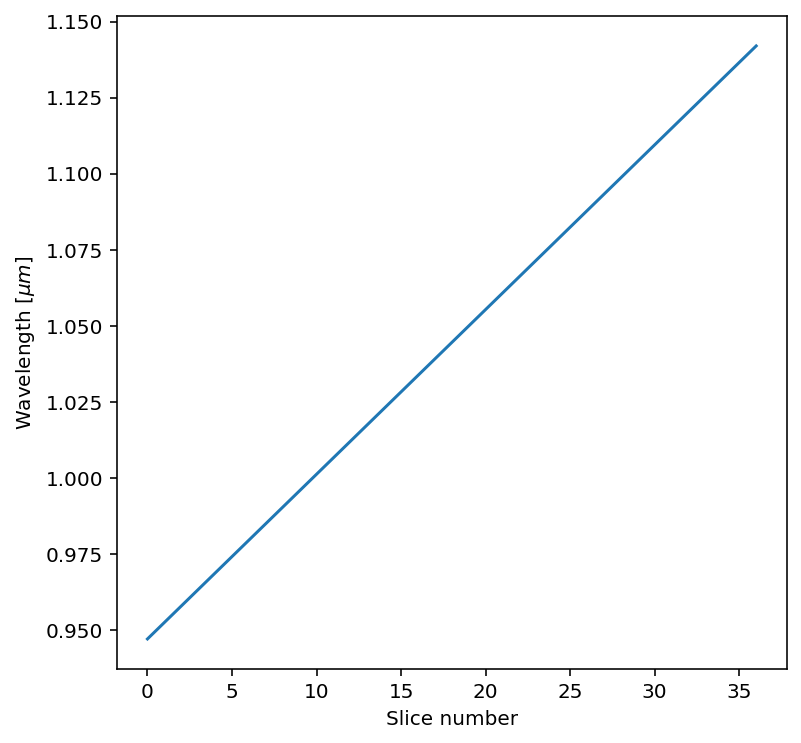

In [13]:
# Q4 answer here
wlen0 = he['CRVAL3']
dwlen = he['CD3_3']
Wavelength = np.arange(wlen0,wlen0+dwlen*37,dwlen)
plt.figure(figsize=(6,6))
plt.plot(Wavelength)
plt.xlabel('Slice number')
plt.ylabel('Wavelength $[\mu m]$')
plt.show()
# Q4 end answer

## Reading in all the spot positions


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.5</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Write a function `sat_spot_read()` to read in all x,y values of all satellite spots from the header `he` into two arrays of shape (37,4) and return them, i.e.**

    (xspot, yspot) = sat_spot_read(he) 


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.6</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Use `ax.plot()` to plot out all 4 satellite spots and see how their position changes as a fucntion of wavelength. Label the axes 'X position [pixels]' and 'Y position [pixels]'.**


<div class="alert alert-block alert-info">
<b>Note: </b> The Matplotlib function <code>ax.plot()</code> will treat each column along axis 1 as a separate line to plot <br>$\quad\quad\longrightarrow$ you should only have to do <code>ax.plot(xspot,yspot)</code> to get the result you want. </div>

***


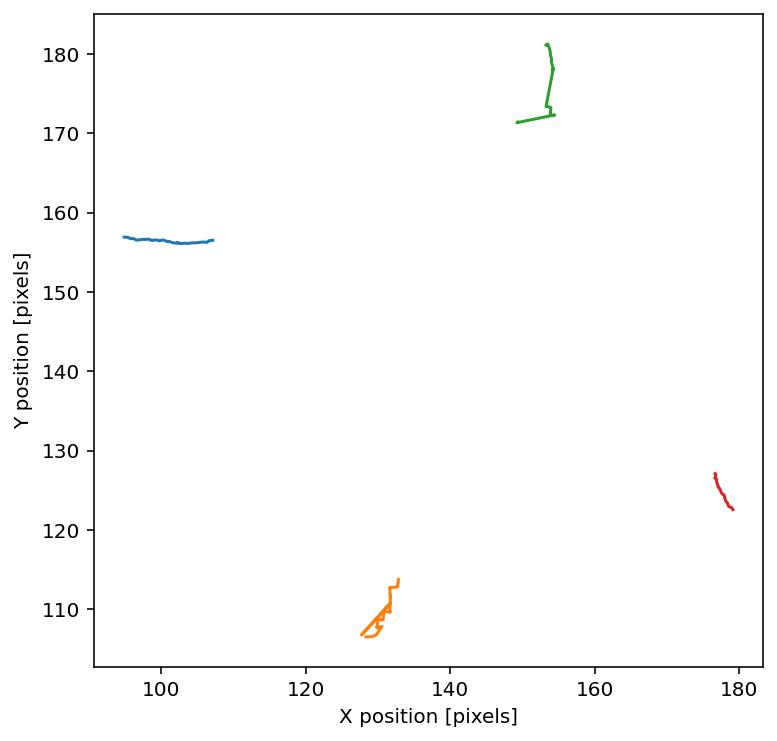

In [14]:
# Q5 answer here

def sat_spot_read(he):
    """sat_spot_read - taking header he from fits file as input, returning  x,y values of all satellite spots
            as spotx, spoty using SATSn_m with n from 0 to 36 and m from 0 to 3 """
    xspot = np.zeros((37,4))
    yspot = np.zeros((37,4))
    for i in range(37):
        for j in range(4):
            pos = he['SATS{}_{}'.format(i,j)]
            xspot[i][j],yspot[i][j] = np.fromstring(pos,sep=' ')
    return (xspot,yspot)

xspot,yspot = sat_spot_read(he)
# Q5 end answer 


# Q6 answer here
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(xspot,yspot)
ax.set_xlabel('X position [pixels]')
ax.set_ylabel('Y position [pixels]')
plt.show()
# Q6 end answer 

## Variation of PSF center with wavelength

The GPI did not have an atmospheric dispersion corrector (ADC) installed when this data was taken. As a result the image of the star is smeared out into a spectrum. In other words, the position of the centre of the stellar PSF changes with wavelength.

The centre of the stellar PSF is at the midpoint between all four satellite spots, but due to problems with the routine that identified the spots, only spots 0 and 3 can be reliably used (the spots should make approximately straight lines in the plot from the previous question, whilst spots 1 and 2 jump around the place). 


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.7</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

1. **Calculate the estimated PSF centre (call it `star_xcen`,`star_ycen`) for each wavelength slice by finding the midpoint between satellite spoty 0 and 3 for each wavelength.** 
* **Plot this value as `star_xcen` versus `star_ycen` using `ax.plot`.**
* **Label the axes `Star x position [pixels]` and `Star y position [pixels]`.**

***
    

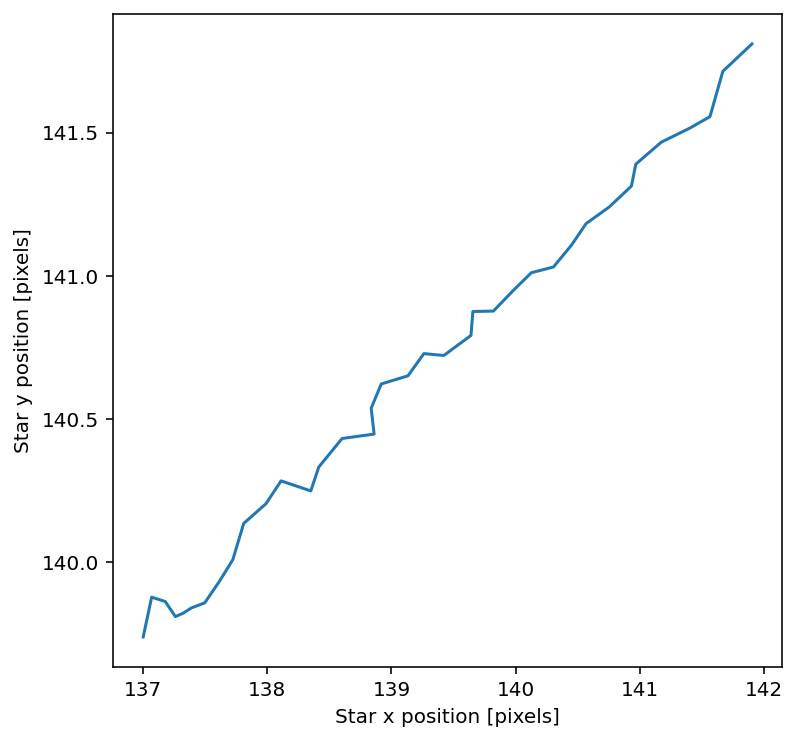

In [15]:
# Q7 answer here

star_xcen = .5*(xspot[:,0]+xspot[:,3])
star_ycen = .5*(yspot[:,0]+yspot[:,3])

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(star_xcen,star_ycen)
ax.set_xlabel('Star x position [pixels]')
ax.set_ylabel('Star y position [pixels]')
plt.show()
# Q7 end answer 

## Comparing the wavelengths


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.8</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

1. **Calculate the separation in pixels between the two satellite spots at each wavelength and call it `spot_separation`.** 

<div class="alert alert-block alert-info">
<b>Tip: </b> The separation between satellite spots should be directly proportional to the wavelength of the image slice. </div>

2. **Show that this is true by plotting the image slice wavelength versus the spot separation and label the axes appropriately.**

***
    

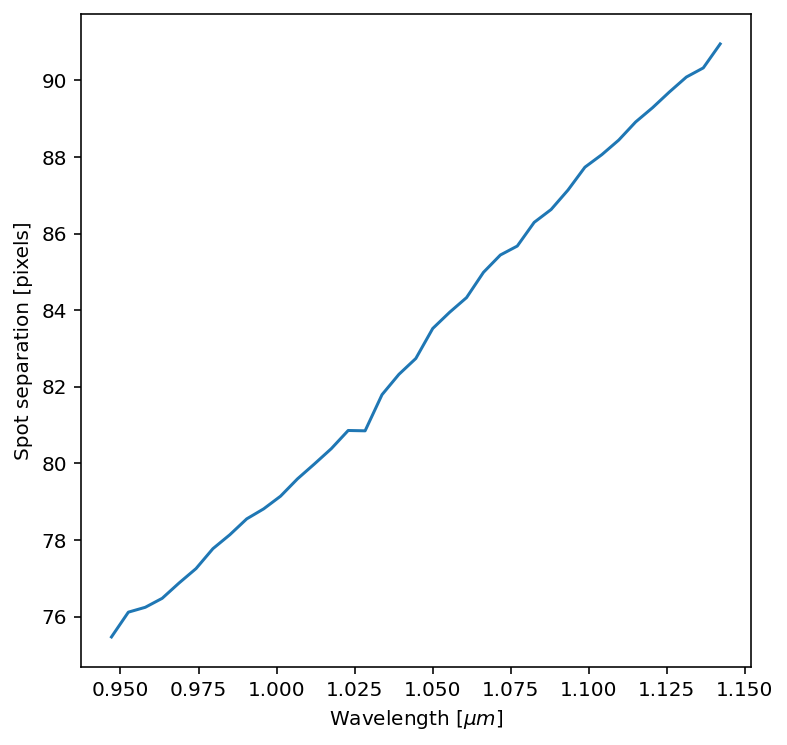

In [16]:
# Q8 answer here

separation = np.sqrt((xspot[:,0]-xspot[:,3])**2+(yspot[:,0]-yspot[:,3])**2)
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(Wavelength,separation)
ax.set_xlabel('Wavelength $[\mu m]$')
ax.set_ylabel('Spot separation [pixels]')
plt.show()
# Q8 end answer

## Calculating the magnification needed for aligning the satellite spots

You need a magnification factor for each image so that all the satellite spots are in the same position in the output cube.

We will scale up (upsample) the images to the image with the largest separation between the satellite spots, i.e. the longest wavelength.


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.9</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

1. **Generate the numpy array `mag` that has a magnification of 1.0 for the longest wavelength - all other magnifications should be larger than 1.**
* **Plot out `mag` as a function of frame number and label the axes.**

***


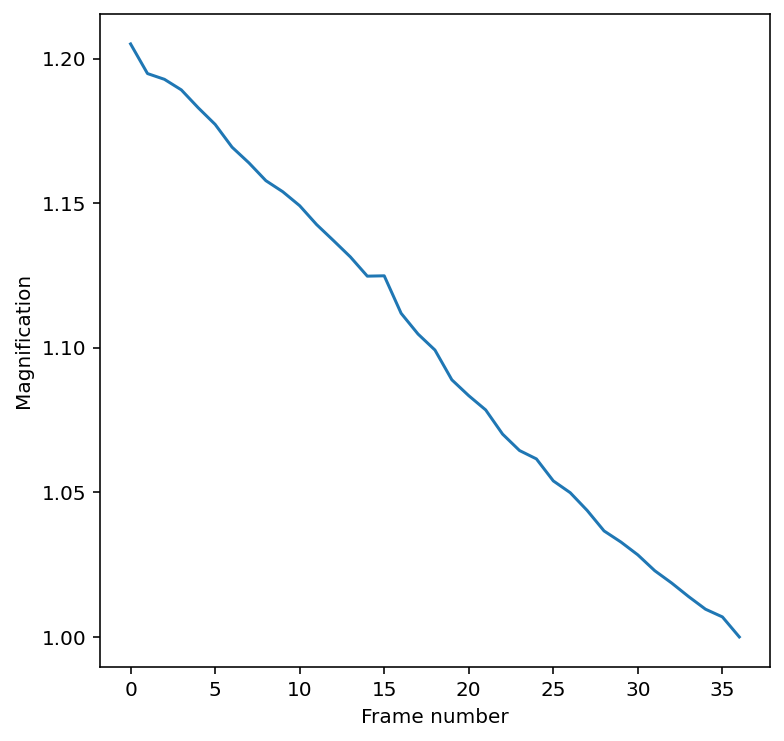

In [17]:
# Q9 answer here

mag = separation[-1]/separation
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(mag)
ax.set_xlabel('Frame number')
ax.set_ylabel('Magnification')
plt.show()

# Q9 end answer

## Rescaling the data cube to the same $\lambda/D$

We have now calculated `mag` and we have the data cube `im` and the centroids of the star as a function of wavelength in `star_xcen` and `star_ycen`. This allows you to rescale all image slices to the same $\lambda/D$ resolution so that in the output cube the satellite spots are in the same position and the centre of the stellar PSF is in the same location.

---
<span style="  font-size:2em; color: SteelBlue;">Question 8.10</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Use `descale()` to make a data cube that is 250 by 250 pixels in size, where each image is magnified by a factor of `mag`. Call the descaled data cube `sdi1`.**

**Write this image cube out to `sdi1_cube.fits` and use ds9 to convince yourself that all the images have the satellite spots in the same x,y positions in the cube.**


<div class="alert alert-block alert-info">
<b>Recall: </b> x and y positions in numpy arrays are usually the other way around... </div>

***


In [18]:
# Q10 answer here
sdil = descale(im,mag,(250,250),(star_xcen[-1],star_ycen[-1]))
wfits(sdil,'sdil_cube.fits')
# Q10 end answer

In [19]:
#%run ds9 sdil_cube.fits

## Calculate the flux normalisation

The throughput of the instrument varies as a function of wavelength. This requires you to estimate the throughput by looking at one of the satellite spots and adding up the flux with a box centered on one of the satellite spots.

Pick the satellite spot at around 170, 110 (but CHECK that it is there first! Do not assume I am giving you the exact values... by this point in the course you should be thinking of sensible checks for what I tell you and asking yourself "Do I see the satellite spot in this precise location?") and sum up the flux in each image slice on a box centered on this satellite spot, with a box width of 10 pixels. 

Call this `spot_sum`


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.11</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Plot out the flux as a function of wavelength and label the axes appropriately.**

***



In [20]:
def zoom(im,x,y,bb):
    '''zoom - returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

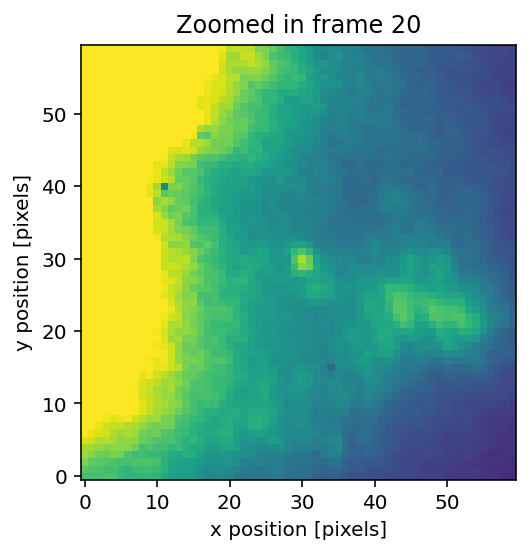

In [21]:
# Q11 answer here
# sanity check
# I see the satellite spot at 166,112
satellite_x = 166
satellite_y = 112
plt.imshow(zoom(sdil[20],satellite_x,satellite_y,30),vmin=0,vmax=300)
plt.xlabel('x position [pixels]')
plt.ylabel('y position [pixels]')
plt.title('Zoomed in frame 20')
plt.show()
spot_sum = np.sum(sdil[:,satellite_x-5:satellite_x+5,satellite_y-5:satellite_y+5],axis=(1,2))
# Q11 end answer

## Normalise the `sdi1` cube

Normalise the `sdi1` cube by the summed flux (don't worry about normalising the whole flux curve, we'll be dividing it out again in a minute) and call it `sdi1_norm`.

Write this out to a FITS file and make a sanity check that you've got approximately the same flux in the satellite spots by examining the satellite spots in `ds9`.


In [22]:
# normalise the flux

sdil_norm = sdil/spot_sum[:,np.newaxis,np.newaxis]
wfits(sdil_norm,'sdil_norm.fits')


In [23]:
#%run ds9 sdil_norm.fits

## Removing the diffraction structures

Taking the median of `sdi1_norm` then removes the planet, leaving all the diffraction structures in place.

Take the median of `sdi1_norm` and subtract it off the individual frames in `sdi1_norm`, and call this `sdi1_norm_sub`

Remove the flux normalisation by multiplying `sdi1_norm_sub` by `spot_sum`.

In [24]:
sdil_norm_sub = sdil_norm - np.median(sdil_norm,axis=(1,2))[:,np.newaxis,np.newaxis]
sdil_norm_sub = sdil_norm_sub*spot_sum[:,np.newaxis,np.newaxis]

## Scale back to the sky plate scale
The last part of SDI is to demagnify the image cube and take the mean of the cube to see the planet.

Remember that you can use `descale()` to unmagnify the image frames, but now move the star to be at the centre of a 250 by 250 pixel array. Call this `sdi_out`.

In [25]:
# demagnify the images back to original
demag = 1/mag
star_cenx = np.array([125])
star_ceny = star_cenx
sdi_out = descale(sdil_norm_sub,demag,(250,250),(star_cenx,star_ceny))
wfits(sdi_out,'sdi_out.fits')

## Display the planet


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.12</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Take the mean of all the images in `sdi_out` and display the image with a range of -10 to 200.**

**Answer the question: What is the approximate position of the companion with respect to the central star?**

***


In [26]:
#%run ds9 sdi_out.fits

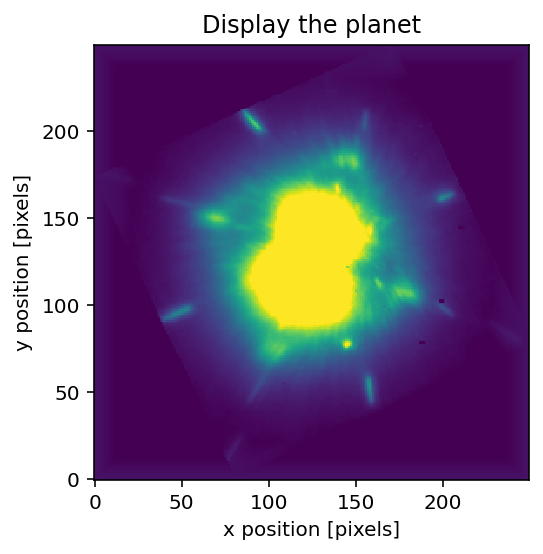

In [27]:
# Q12 answer here
im_planet = np.mean(sdi_out,axis=0)
plt.imshow(im_planet,vmin=-10,vmax=200)
plt.xlabel('x position [pixels]')
plt.ylabel('y position [pixels]')
plt.title('Display the planet')
plt.show()
# Q12 end answer

Answer: with the central star relocated at (125,125), now the companion is at approximately (148,78).


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it! Do <b>NOT</b> send your fits cubes back! Only this Jupyter notebook!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


~ 3 hours.